Calculating Seasonal Averages from Timeseries of Monthly Means 
=====

Author: [Joe Hamman](https://github.com/jhamman/)

The data used for this example can be found in the [xarray-data](https://github.com/pydata/xarray-data) repository. You may need to change the path to `rasm.nc` below.

Suppose we have a netCDF or `xarray.Dataset` of monthly mean data and we want to calculate the seasonal average.  To do this properly, we need to calculate the weighted average considering that each month has a different number of days.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 

#### Open the `Dataset`

In [2]:
ds = xr.tutorial.open_dataset('rasm').load()
ds

<xarray.Dataset>
Dimensions:  (time: 36, x: 275, y: 205)
Coordinates:
  * time     (time) object 1980-09-16 12:00:00 ... 1983-08-17 00:00:00
    xc       (y, x) float64 189.2 189.4 189.6 189.7 ... 17.65 17.4 17.15 16.91
    yc       (y, x) float64 16.53 16.78 17.02 17.27 ... 28.26 28.01 27.76 27.51
Dimensions without coordinates: x, y
Data variables:
    Tair     (time, y, x) float64 nan nan nan nan nan ... 29.8 28.66 28.19 28.21
Attributes:
    title:                     /workspace/jhamman/processed/R1002RBRxaaa01a/l...
    institution:               U.W.
    source:                    RACM R1002RBRxaaa01a
    output_frequency:          daily
    output_mode:               averaged
    convention:                CF-1.4
    references:                Based on the initial model of Liang et al., 19...
    comment:                   Output from the Variable Infiltration Capacity...
    nco_openmp_thread_number:  1
    NCO:                       "4.6.0"
    history:                   Tue Dec 27 14:15:22 2016: ncatted -a dimension...

#### Now for the heavy lifting:
We first have to come up with the weights,
- calculate the month lengths for each monthly data record
- calculate weights using `groupby('time.season')`

Finally, we just need to multiply our weights by the `Dataset` and sum allong the time dimension.  Creating a `DataArray` for the month length is as easy as using the `days_in_month` accessor on the time coordinate.  The calendar type, in this case `'noleap'`, is automatically considered in this operation.

In [3]:
month_length = ds.time.dt.days_in_month
month_length

<xarray.DataArray 'days_in_month' (time: 36)>
array([30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31,
       28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30,
       31, 31])
Coordinates:
  * time     (time) object 1980-09-16 12:00:00 ... 1983-08-17 00:00:00

In [4]:
# Calculate the weights by grouping by 'time.season'.
weights = month_length.groupby('time.season') / month_length.groupby('time.season').sum()

# Test that the sum of the weights for each season is 1.0
np.testing.assert_allclose(weights.groupby('time.season').sum().values, np.ones(4))

# Calculate the weighted average
ds_weighted = (ds * weights).groupby('time.season').sum(dim='time')

In [5]:
ds_weighted

<xarray.Dataset>
Dimensions:  (season: 4, x: 275, y: 205)
Coordinates:
    yc       (y, x) float64 16.53 16.78 17.02 17.27 ... 28.26 28.01 27.76 27.51
    xc       (y, x) float64 189.2 189.4 189.6 189.7 ... 17.65 17.4 17.15 16.91
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Dimensions without coordinates: x, y
Data variables:
    Tair     (season, y, x) float64 0.0 0.0 0.0 0.0 ... 23.15 22.08 21.73 21.96

In [6]:
# only used for comparisons
ds_unweighted = ds.groupby('time.season').mean('time')
ds_diff = ds_weighted - ds_unweighted

/Users/spencer/Software/xarray/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Text(0.5, 1.02, 'Seasonal Surface Air Temperature')

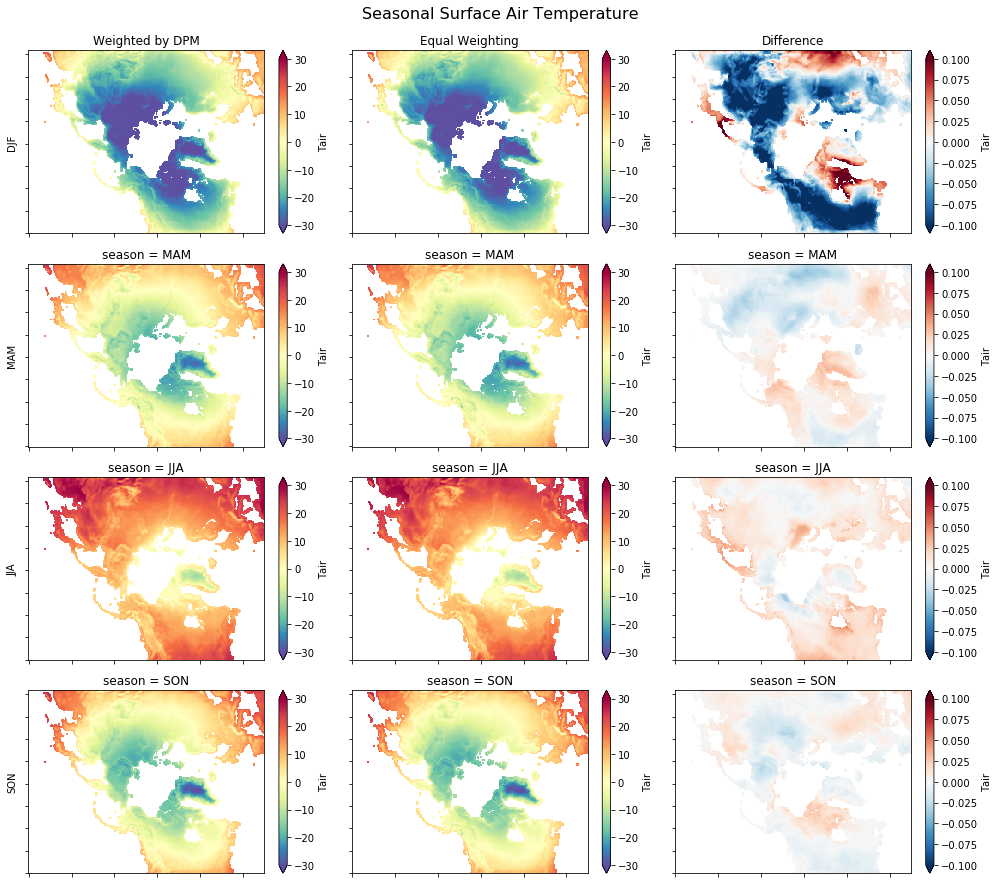

In [7]:
# Quick plot to show the results
notnull = pd.notnull(ds_unweighted['Tair'][0])

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(14,12))
for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    ds_weighted['Tair'].sel(season=season).where(notnull).plot.pcolormesh(
        ax=axes[i, 0], vmin=-30, vmax=30, cmap='Spectral_r', 
        add_colorbar=True, extend='both')
    
    ds_unweighted['Tair'].sel(season=season).where(notnull).plot.pcolormesh(
        ax=axes[i, 1], vmin=-30, vmax=30, cmap='Spectral_r', 
        add_colorbar=True, extend='both')

    ds_diff['Tair'].sel(season=season).where(notnull).plot.pcolormesh(
        ax=axes[i, 2], vmin=-0.1, vmax=.1, cmap='RdBu_r',
        add_colorbar=True, extend='both')

    axes[i, 0].set_ylabel(season)
    axes[i, 1].set_ylabel('')
    axes[i, 2].set_ylabel('')

for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    
axes[0, 0].set_title('Weighted by DPM')
axes[0, 1].set_title('Equal Weighting')
axes[0, 2].set_title('Difference')
        
plt.tight_layout()

fig.suptitle('Seasonal Surface Air Temperature', fontsize=16, y=1.02)

In [8]:
# Wrap it into a simple function
def season_mean(ds, calendar='standard'):
    # Make a DataArray with the number of days in each month, size = len(time)
    month_length = ds.time.dt.days_in_month

    # Calculate the weights by grouping by 'time.season'
    weights = month_length.groupby('time.season') / month_length.groupby('time.season').sum()

    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weights.groupby('time.season').sum().values, np.ones(4))

    # Calculate the weighted average
    return (ds * weights).groupby('time.season').sum(dim='time')